### Imports & Logging Setup

In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import logging

# Machine Learning
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, make_scorer

# Suppress warnings
warnings.simplefilter("ignore")

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Data & Select Features

In [2]:
# File paths (Updated to include NCA and RFE)
file_paths = {
    "fold_change": "../results/fold_change_results.csv",
    "chi_squared": "../results/chi_squared_features.csv",
    "information_gain": "../results/information_gain_results.csv",
    "lasso": "../results/lasso_results.csv",
    "nca": "../results/nca_results.csv",
    "rfe": "../results/recursive_feature_elimination/recursive_feature_selection_general.csv",
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Define the target task
target_task = "stage"  # options: "diagnosis", "stage", "subtype"

# Function to load features specific to the classification task
def load_features_by_task(file_paths, target, num_features=10):
    feature_sets = {}

    for key, path in file_paths.items():
        if key == "processed_data":
            continue

        if os.path.exists(path):
            df = pd.read_csv(path)

            # Use column matching to pull task-specific columns if available
            if target in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, target)["Feature"])

            # Handle known formats for specific methods
            elif key == "fold_change" and "log2_fold_change" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "log2_fold_change")["Unnamed: 0"])
            elif key == "chi_squared" and "Score" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Score")["Feature"])
            elif key == "information_gain" and "Info_Gain_General" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Info_Gain_General")["Feature"])
            elif key == "lasso" and "Coefficient" in df.columns:
                feature_sets[key] = set(df.nlargest(num_features, "Coefficient")["Feature"])
            elif key in ["nca", "rfe"] and "Feature" in df.columns:
                feature_sets[key] = set(df["Feature"][:num_features])
            else:
                logging.warning(f"Unexpected format in {key}, skipping.")
        else:
            logging.warning(f"Feature selection file missing: {path}")

    combined_features = set().union(*feature_sets.values())
    logging.info(f"[{target.upper()}] Total unique features selected: {len(combined_features)}")
    return list(combined_features)

# Select features for the current task
num_features_to_select = 10
top_features = load_features_by_task(file_paths, target_task, num_features=num_features_to_select)


2025-03-28 23:45:59,333 - INFO - [STAGE] Total unique features selected: 58


### Process Features & Labels for Multi-Output Classification

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Ensure processed data is loaded
file_path = file_paths.get("processed_data", None)
if file_path and os.path.exists(file_path):
    processed_data = pd.read_csv(file_path)
    logging.info(f"Processed data loaded successfully. Shape: {processed_data.shape}")
else:
    raise FileNotFoundError(f"Processed data file is missing: {file_path}")

# Debug: Print column names
print("\nAvailable columns in processed_data:")
print(processed_data.columns)

# Create "diagnosis" column if missing
if "diagnosis" not in processed_data.columns:
    logging.warning("Column 'diagnosis' is missing. Deriving from 'subtype'.")
    processed_data["diagnosis"] = processed_data["subtype"].apply(lambda x: 0 if x == 0 else 1)
    logging.info("'diagnosis' column successfully created.")

# Ensure the specific label exists
if target_task not in processed_data.columns:
    raise KeyError(f"Missing expected label column: '{target_task}'.")

# Function to process features and labels
def process_features_and_labels(processed_data, selected_features, target):
    """
    Filters processed data for selected features and extracts the target label.

    Args:
        processed_data (pd.DataFrame): Data containing features and target variables.
        selected_features (list): List of feature names to filter.
        target (str): Target column name.

    Returns:
        tuple: Processed feature dataframe (X) and label series (y).
    """
    missing_features = [f for f in selected_features if f not in processed_data.columns]
    if missing_features:
        logging.warning(f"{len(missing_features)} features missing from dataset! Missing: {missing_features}")

    # Stop if more than 50% of features are missing
    missing_ratio = len(missing_features) / len(selected_features)
    if missing_ratio > 0.5:
        raise ValueError(f"More than 50% of selected features are missing! ({missing_ratio * 100:.2f}%)")

    selected_features = [f for f in selected_features if f in processed_data.columns]

    # Extract features and target label
    X = processed_data[selected_features].apply(pd.to_numeric, errors='coerce')
    y = processed_data[target].astype(int)

    # Handle missing values
    if X.isnull().values.any() or y.isnull().values.any():
        logging.warning("Missing values detected in features or labels.")
        print("\nMissing values per feature (Top 5):")
        print(X.isnull().sum()[X.isnull().sum() > 0].head())
        print("\nMissing values in target:")
        print(y.isnull().sum())
        valid_indices = ~(X.isnull().any(axis=1) | y.isnull())
        X = X[valid_indices]
        y = y[valid_indices]

    # Standardize features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    logging.info("Features have been standardized.")

    # Stratify based on the actual task
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    logging.info(f"Training Set Shape: {X_train.shape}")
    logging.info(f"Test Set Shape: {X_test.shape}")
    logging.info(f"Class distribution in training set:\n{y_train.value_counts(normalize=True)}")

    return X_train, X_test, y_train, y_test

# Process the data for current task
X_train, X_test, y_train, y_test = process_features_and_labels(processed_data, top_features, target_task)

# Debug
print("\nExpression values sample:")
print(X_train.head())

print("\nFeature statistics:")
print(X_train.describe())

print(f"\nClass proportions in train set for '{target_task}':")
print(y_train.value_counts(normalize=True))

2025-03-28 23:50:03,854 - INFO - Processed data loaded successfully. Shape: (1091, 1883)
2025-03-28 23:50:03,855 - WARNING - Column 'diagnosis' is missing. Deriving from 'subtype'.
2025-03-28 23:50:03,856 - INFO - 'diagnosis' column successfully created.
2025-03-28 23:50:03,867 - INFO - Features have been standardized.
2025-03-28 23:50:03,869 - INFO - Training Set Shape: (872, 58)
2025-03-28 23:50:03,870 - INFO - Test Set Shape: (219, 58)
2025-03-28 23:50:03,871 - INFO - Class distribution in training set:
stage
1    0.518349
2    0.282110
3    0.160550
4    0.028670
0    0.010321
Name: proportion, dtype: float64



Available columns in processed_data:
Index(['hsa-let-7a-1', 'hsa-let-7a-2', 'hsa-let-7a-3', 'hsa-let-7b',
       'hsa-let-7c', 'hsa-let-7d', 'hsa-let-7e', 'hsa-let-7f-1',
       'hsa-let-7f-2', 'hsa-let-7g',
       ...
       'hsa-mir-943', 'hsa-mir-944', 'hsa-mir-95', 'hsa-mir-9500',
       'hsa-mir-96', 'hsa-mir-98', 'hsa-mir-99a', 'hsa-mir-99b', 'stage',
       'subtype'],
      dtype='object', length=1883)

Expression values sample:
     hsa-mir-596  hsa-mir-519d  hsa-mir-1181  hsa-mir-6770-1  hsa-mir-186  \
191    -0.127821     -0.072234     -0.564659       -0.122292     0.265495   
331    -0.127821      0.015480      0.869440       -0.122292    -0.521156   
651    -0.127821     -0.028275     -0.205302       -0.122292    -0.992991   
243    -0.127821     -0.072234      0.094320       -0.122292     1.196246   
571    -0.127821     -0.052985     -0.249948       -0.122292    -0.929996   

     hsa-mir-181d  hsa-mir-135a-1  hsa-mir-4271  hsa-mir-3973  hsa-mir-185  \
191     -0.805023

### Dynamic Label Handling for One Target Only

In [4]:
# Log split info
print("\nTrain-Test Split Information:")
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

# Print class distribution for the current task
print(f"\nTraining set class distribution ({target_task}):")
print(y_train.value_counts(normalize=True))

print(f"\nTesting set class distribution ({target_task}):")
print(y_test.value_counts(normalize=True))


Train-Test Split Information:
Training set: (872, 58), Testing set: (219, 58)

Training set class distribution (stage):
stage
1    0.518349
2    0.282110
3    0.160550
4    0.028670
0    0.010321
Name: proportion, dtype: float64

Testing set class distribution (stage):
stage
1    0.520548
2    0.283105
3    0.159817
4    0.027397
0    0.009132
Name: proportion, dtype: float64


### Train Multi-Output SVM Model

In [7]:
import warnings
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Suppress warnings
warnings.simplefilter("ignore")

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

print(f"\nTraining SVM for {target_task.upper()}...")

# Define & train model with GridSearchCV
svm = SVC(class_weight="balanced", random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Predict
y_pred = grid_search.best_estimator_.predict(X_test)

# Report
print(f"\nBest SVM Hyperparameters for {target_task.upper()}: {grid_search.best_params_}")
print(f"\nClassification Report for {target_task.upper()}:\n",
      classification_report(y_test, y_pred, zero_division=0))


Training SVM for STAGE...

Best SVM Hyperparameters for STAGE: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Classification Report for STAGE:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.92      0.98      0.95       114
           2       0.98      0.87      0.92        62
           3       0.94      0.91      0.93        35
           4       1.00      0.83      0.91         6

    accuracy                           0.94       219
   macro avg       0.90      0.92      0.90       219
weighted avg       0.94      0.94      0.94       219



### Evaluate Multi-Output Model & Feature Selection Insights


-------------------- SVM_Stage Results --------------------

Accuracy: 0.9361
Sensitivity (Recall): 0.9202
Specificity: 0.9015

Confusion Matrix:
 [[  2   0   0   0   0]
 [  1 112   0   1   0]
 [  0   8  54   0   0]
 [  0   2   1  32   0]
 [  0   0   0   1   5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.92      0.98      0.95       114
           2       0.98      0.87      0.92        62
           3       0.94      0.91      0.93        35
           4       1.00      0.83      0.91         6

    accuracy                           0.94       219
   macro avg       0.90      0.92      0.90       219
weighted avg       0.94      0.94      0.94       219



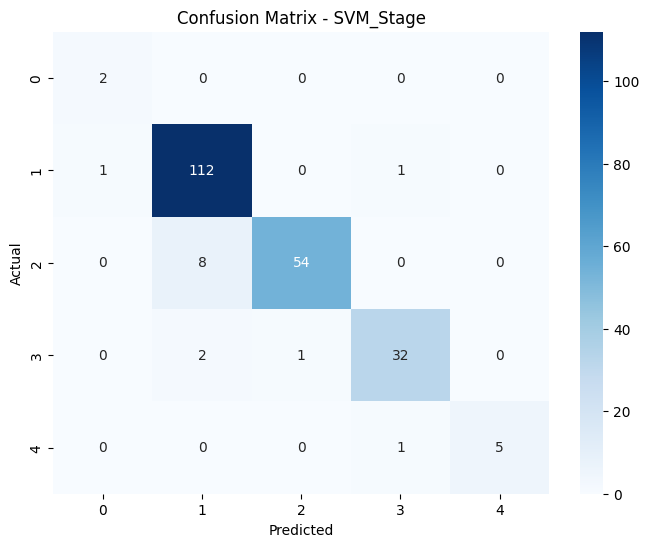


Confusion matrix saved to ../results/svm/svm_stage_confusion_matrix.png


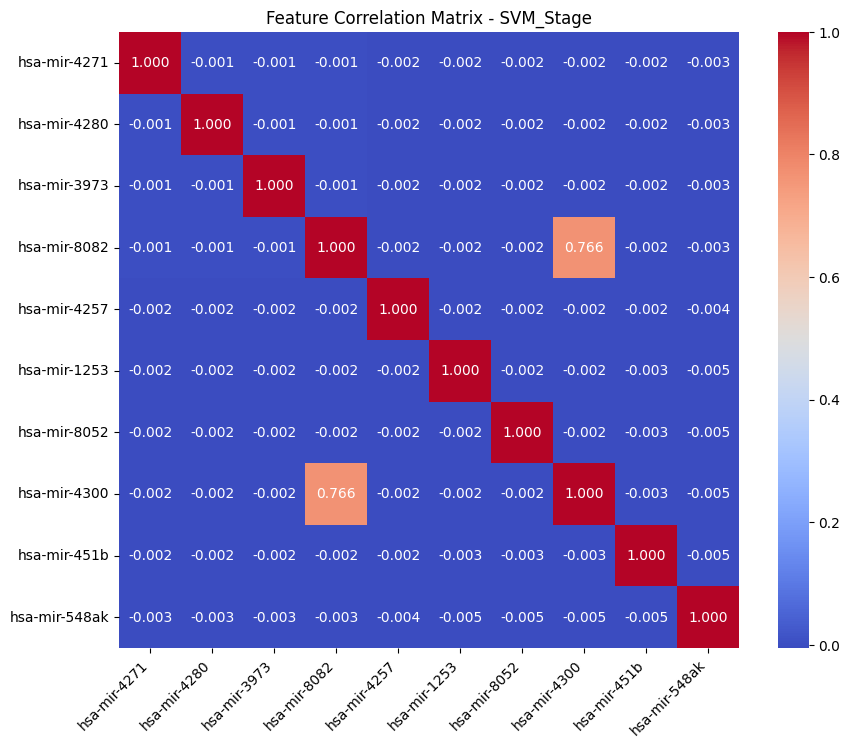


Correlation matrix saved to ../results/svm/svm_stage_correlation_matrix.png


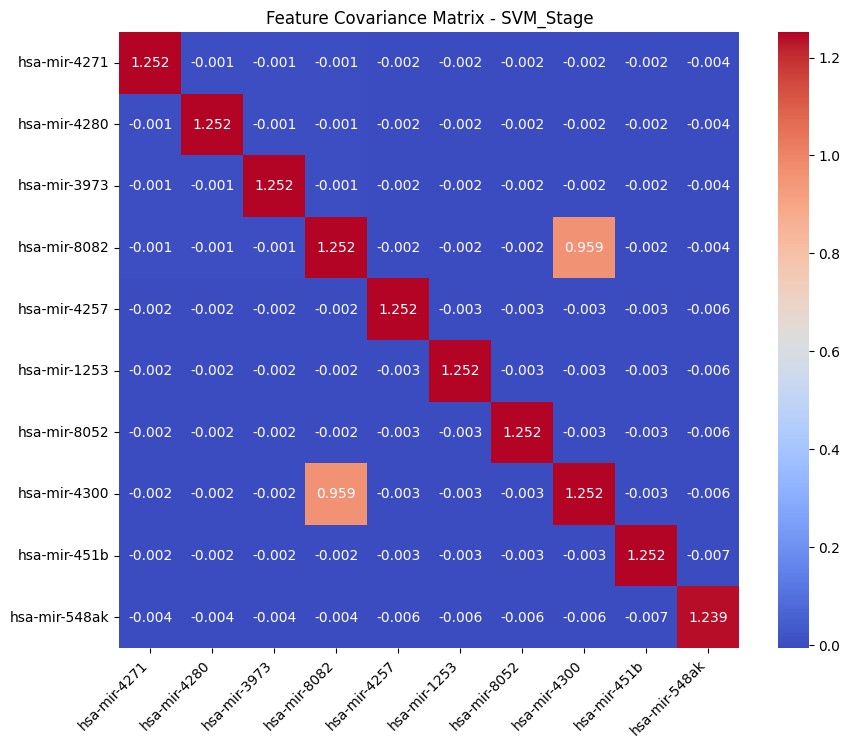


Covariance matrix saved to ../results/svm/svm_stage_covariance_matrix.png

Top features saved to ../results/svm/svm_stage_top_features.txt


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Logging Setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def evaluate_model(y_test, y_pred, X_train, model_name, save_dir="../results/svm/"):
    os.makedirs(save_dir, exist_ok=True)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    if cm.shape == (2, 2):  # Binary classification
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    else:  # Multiclass
        sensitivity = np.mean(np.diag(cm) / np.sum(cm, axis=1))
        specificity = np.mean(np.diag(cm) / np.sum(cm, axis=0))

    # Print Metrics
    print(f"\n{'-'*20} {model_name} Results {'-'*20}")
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    # Save Confusion Matrix Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    cm_path = os.path.join(save_dir, f"{model_name.lower()}_confusion_matrix.png")
    plt.savefig(cm_path)
    plt.show()
    print(f"\nConfusion matrix saved to {cm_path}")

    # Correlation Matrix
    top_vars = X_train.var().sort_values(ascending=False).index[:10]
    corr_matrix = X_train[top_vars].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".3f")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.title(f"Feature Correlation Matrix - {model_name}")
    corr_path = os.path.join(save_dir, f"{model_name.lower()}_correlation_matrix.png")
    plt.savefig(corr_path)
    plt.show()
    print(f"\nCorrelation matrix saved to {corr_path}")

    # Covariance Matrix
    cov_matrix = X_train[top_vars].cov()
    plt.figure(figsize=(10, 8))
    sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", fmt=".3f")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.title(f"Feature Covariance Matrix - {model_name}")
    cov_path = os.path.join(save_dir, f"{model_name.lower()}_covariance_matrix.png")
    plt.savefig(cov_path)
    plt.show()
    print(f"\nCovariance matrix saved to {cov_path}")

    # Save top features by variance
    top_features_path = os.path.join(save_dir, f"{model_name.lower()}_top_features.txt")
    with open(top_features_path, "w") as f:
        for feature in top_vars:
            f.write(feature + "\n")
    print(f"\nTop features saved to {top_features_path}")

    return {
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "confusion_matrix": cm.tolist(),
        "top_10_features": top_vars.tolist()
    }

# Call the function for current task
model_name = f"SVM_{target_task.capitalize()}"
metrics = evaluate_model(y_test, y_pred, X_train, model_name=model_name)

### Save Everything & Finalize the Pipeline

In [9]:
import os
import json
import pandas as pd
import joblib
import logging

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define Output Directory
output_dir = "../results/svm/"
os.makedirs(output_dir, exist_ok=True)

# Save Predictions
pred_df = pd.DataFrame({"actual": y_test, "predicted": y_pred})
pred_path = os.path.join(output_dir, f"svm_predictions_{target_task.lower()}.csv")
pred_df.to_csv(pred_path, index=False)
logging.info(f"{target_task.capitalize()} predictions saved to {pred_path}")

# Save Metadata
metadata = {
    f"{target_task}_accuracy": metrics["accuracy"],
    f"{target_task}_sensitivity": metrics["sensitivity"],
    f"{target_task}_specificity": metrics["specificity"],
    f"top_10_features_{target_task}": metrics["top_10_features"],
    "train_size": X_train.shape[0],
    "test_size": X_test.shape[0],
    "target_task": target_task
}

metadata_path = os.path.join(output_dir, f"svm_metadata_{target_task.lower()}.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
logging.info(f"Metadata saved to {metadata_path}")

# Save Trained Model
model_path = os.path.join(output_dir, f"svm_model_{target_task.lower()}.pkl")
joblib.dump(grid_search.best_estimator_, model_path)
logging.info(f"{target_task.capitalize()} model saved to {model_path}")

print(f"\nAll results saved for {target_task.upper()} SVM. Pipeline complete!")

2025-03-29 00:08:19,703 - INFO - Stage predictions saved to ../results/svm/svm_predictions_stage.csv
2025-03-29 00:08:19,705 - INFO - Metadata saved to ../results/svm/svm_metadata_stage.json
2025-03-29 00:08:19,708 - INFO - Stage model saved to ../results/svm/svm_model_stage.pkl



All results saved for STAGE SVM. Pipeline complete!
